# Twitter Sentiment Analysis

## Imports

In [2]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import re
import pandas as pd 
import string
import statistics

import sklearn
from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data Loading and Exploring

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0
corpus = []

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

--2019-12-10 20:50:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   146MB/s    in 1.6s    

2019-12-10 20:50:56 (146 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [4]:
print(num_sentences)
print(len(corpus))
print(corpus[:2])

1600000
1600000
[["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", 0], ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]]


In [0]:
sentences=[]
labels=[]
random.shuffle(corpus)

for x in range(len(corpus)):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

## Parameters

In [0]:
embedding_dim = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
max_length = 16

# will only use 20% of all data for training and validation
training_size=int(len(corpus)*.1)
test_portion=.1
num_epochs = 50

## Data Preprocessing

In [0]:
# Dataset is too big so will use only 10% of it
sentences=sentences[:training_size]
labels=labels[:training_size]

In [0]:
# function to preprocess text
def preprocess_tweet(text):

    # remove URLs
    nopunc = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)
    nopunc = re.sub(r'http\S+', '', nopunc)

    # remove usernames
    nopunc = re.sub('@[^\s]+', '', nopunc)

    # remove the # in #hashtag
    nopunc = re.sub(r'#([^\s]+)', r'\1', nopunc)

    # remove special characters, numbers, punctuations
    nopunc = re.sub('[^A-Za-z0-9]+', ' ', nopunc)
    
    # remove short words
    nopunc = re.sub(r'\b\w{1,2}\b','', nopunc)

    # remove duplicate words
    nopunc = re.sub(r'\b(\w+)( \1\b)+', r'\1', nopunc)

    # remove repeated characters
    nopunc = word_tokenize(nopunc)

    # remove stopwords from final word list
    return [word.lower() for word in nopunc if word not in stopwords.words('english')]

In [9]:
# cleaning data
final = []

n = len(sentences)/4
counter = 0

for x in sentences:
    final.append(preprocess_tweet(x))
    counter += 1
    if counter % n == 0:
        print(f'{counter / len(sentences) * 100} % done')

print(f'Orginal tweet: {sentences[:2]}')
print(f'Processed tweet: {final[:2]}')

25.0 % done
50.0 % done
75.0 % done
100.0 % done
Orginal tweet: ['YES talent show today!  -aaron', '@SmittenKitten4D i KNOW!!!!  i hope they another!! I get sea sick- but its cool now,donnie gets sick too- so its the &quot;in&quot; thing! haha x']
Processed tweet: [['yes', 'talent', 'show', 'today', 'aaron'], ['know', 'hope', 'another', 'get', 'sea', 'sick', 'cool', 'donnie', 'gets', 'sick', 'quot', 'quot', 'thing', 'haha']]


In [0]:
# tokeninzing tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(final)

# getting word indexes
word_index = tokenizer.word_index
vocab_size=len(word_index)

# creating sequences and padding with max lenth of 7 words
sequences = tokenizer.texts_to_sequences(final)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# One hot encoding of labels
df = pd.DataFrame(labels)
labels = pd.get_dummies(df, columns=[0])

# Rename cloumns to 'Positive' and 'Negative'.
labels = labels.rename(columns={'0_0': 'Positive', '0_1': 'Negative'})

# Convert data_frame into np arrays of float32
labels = np.asarray(labels.values, dtype='float32')

# splitting test and train
split = int(test_portion * training_size)

training_sequences, training_labels = padded[split:], labels[split:]
test_sequences, test_labels,  = padded[:split], labels[:split]

In [11]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(f'Orginal tweet: {sentences[2]}')
print(f'Processed tweet: {decode_review(padded[2])}')
print(f'Number of unique words: {vocab_size}')

Orginal tweet: Finished my history final review guide  wellll almost
Processed tweet: finished history final review guide wellll almost ? ? ? ? ? ? ? ? ?
Number of unique words: 69170


In [12]:
# Calculating number of positive and negative tweets
positive, negative = np.unique(df[0], return_counts=True)[1]
print(f'Number of positive tweets: {positive}')
print(f'Number of negative tweets: {negative}')

Number of positive tweets: 80127
Number of negative tweets: 79873


## GloVe Embedding

In [13]:
# this is the 100 dimension version of GloVe from Stanford
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

print(f'Vocab size: {vocab_size}')
print(f'Embeddings size: {len(embeddings_matrix)}')

--2019-12-10 20:53:44--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   149MB/s    in 2.2s    

2019-12-10 20:53:46 (149 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]

Vocab size: 69170
Embeddings size: 69171


## Model Training

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           6917100   
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 64)             0         
_______________________________________________________

In [15]:
# Training
history = model.fit(training_sequences,
                    training_labels,
                    epochs=num_epochs,
                    validation_data=(test_sequences, test_labels),
                    verbose=2)

print("Training Complete")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 144000 samples, validate on 16000 samples
Epoch 1/50
144000/144000 - 35s - loss: 0.5767 - acc: 0.6927 - val_loss: 0.5317 - val_acc: 0.7301
Epoch 2/50
144000/144000 - 32s - loss: 0.5469 - acc: 0.7185 - val_loss: 0.5207 - val_acc: 0.7418
Epoch 3/50
144000/144000 - 31s - loss: 0.5372 - acc: 0.7270 - val_loss: 0.5150 - val_acc: 0.7430
Epoch 4/50
144000/144000 - 31s - loss: 0.5291 - acc: 0.7326 - val_loss: 0.5142 - val_acc: 0.7453
Epoch 5/50
144000/144000 - 31s - loss: 0.5239 - acc: 0.7363 - val_loss: 0.5111 - val_acc: 0.7478
Epoch 6/50
144000/144000 - 31s - loss: 0.5177 - acc: 0.7393 - val_loss: 0.5123 - val_acc: 0.7474
Epoch 7/50
144000/144000 - 30s - loss: 0.5158 - acc: 0.7421 - val_loss: 0.5095 - val_acc: 0.7471
Epoch 8/50
144000/144000 - 31s - loss: 0.5118 - acc: 0.7460 - val_loss: 0.5091 - val_acc: 0.7486
Epoch 9/50
144000/144000 - 30s - loss: 0.5102 - acc: 0.7452 - val_loss: 0.5090 

## Model Analysis

<Figure size 432x288 with 0 Axes>

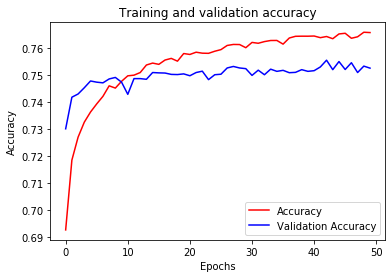

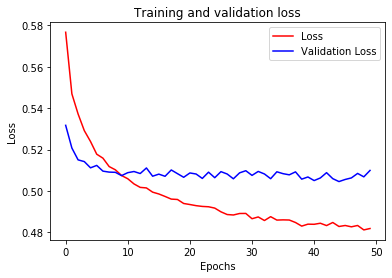

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

In [17]:
# Test the model
y_pred = model.predict(test_sequences)
print('\n', sklearn.metrics.classification_report(np.where(test_labels > 0)[1], 
                                                  np.argmax(y_pred, axis=1)))


               precision    recall  f1-score   support

           0       0.77      0.72      0.74      8030
           1       0.74      0.79      0.76      7970

    accuracy                           0.75     16000
   macro avg       0.75      0.75      0.75     16000
weighted avg       0.75      0.75      0.75     16000



Confusion matrix, without normalization


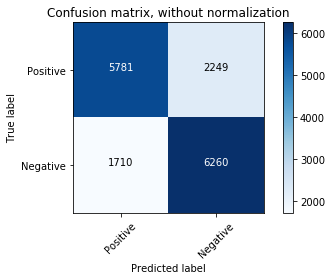

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(np.where(test_labels > 0)[1], np.argmax(y_pred, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = ['Positive','Negative'],
                      title='Confusion matrix, without normalization')

# plt.figure(figsize=(8,8))
# cnf_matrix = sklearn.metrics.confusion_matrix(np.where(test_labels > 0)[1], np.argmax(y_pred, axis=1))
# classes = ['Positive','Negative']
# plt.imshow(cnf_matrix, interpolation='nearest')
# plt.colorbar()
# tick_marks = np.arange(len(classes))
# _ = plt.xticks(tick_marks, classes, rotation=90)
# _ = plt.yticks(tick_marks, classes)

In [0]:
def reset_weights(model):
    import keras.backend as K
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'): 
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias_initializer'):
            layer.bias.initializer.run(session=session)